<a href="https://colab.research.google.com/github/fake-news-unal/fake-news/blob/main/K_means%2Clogistica%2Cbosque%2Carbol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Importar librerías
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Importar keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

# Para la matrix de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import sqlite3

In [ ]:
sqlite_db = "../dataset/fake_news.sqlite"

conn = sqlite3.connect(sqlite_db)
df = pd.read_sql_query("SELECT * FROM NEWS", conn)
conn.close()

In [8]:
df['original'] = df['title'] + '. ' + df['text']
df['original'].replace("..", ".")

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
44893    McPain: John McCain Furious That Iran Treated ...
44894    JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895    Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896    How to Blow $700 Million: Al Jazeera America F...
44897    10 U.S. Navy Sailors Held by Iranian Military ...
Name: original, Length: 44898, dtype: object

#### Total de palabras en el Dataset

In [10]:
list_of_words = []
unique_words = set()
for document in df.clean_joined:
    for word in gensim.utils.simple_preprocess(document):
        list_of_words.append(word)
        unique_words.add(word)
        
total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words))

Total words:8844981 unique_words:96148


### Partición del dataset

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [12]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [13]:
print("Texto original (limpio) \n",df.clean_joined[0],"\n Texto Tokenizado : ",train_sequences[0])

Texto original (limpio) 
 budget fight loom republicans flip fiscal script washington reuters head conservative republican faction congress vote month huge expansion national debt fiscal conservative sunday urge budget restraint sharp pivot republicans representative mark meadows speak face nation draw hard line federal spending lawmaker brace battle january return holiday wednesday lawmaker begin pass federal budget fight likely link issue immigration policy november congressional election campaign approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increase defense discretionary spend program support education scientific research infrastructure public health environmental protection trump administration willing increase defense discretionary spending percent meadows chairman small influential house freedom caucus program democrats need government raise percent fiscal conservative rationale ev

### Word2vec (Vectorización)

In [14]:
#Importando librerías
import string # python library
import re # regex library
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

In [15]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

processed_data = []
processed_labels = []

for index, row in df.iterrows():
    words_broken_up = preprocess_string(row['original'], CUSTOM_FILTERS)
    # Esto elimina cualquier campo que pueda quedar en blanco después del preprocesamiento.
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['isfake'])

In [16]:
model = Word2Vec(processed_data, min_count=1)

In [17]:
model.wv.most_similar("country")

[('nation', 0.8249747157096863),
 ('america', 0.6850860118865967),
 ('countries', 0.5610052347183228),
 ('europe', 0.5588722229003906),
 ('country’s', 0.5447131395339966),
 ('world', 0.5397934317588806),
 ('america’s', 0.5385818481445312),
 ('planet', 0.5361852645874023),
 ('continent', 0.5257173776626587),
 ('prosperous', 0.5241903066635132)]

In [18]:
# Obtener el vector de una oración basado en el promedio de todos los vectores de palabras en la oración
# Obtenemos el promedio ya que esto representa diferentes longitudes de oraciones
def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))


<ipython-input-18-e2e6dfec9562>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return model[x]


In [21]:
X_np = np.array(X)
X_np.shape

(44898, 100)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

# ***Arból de decisión***

In [23]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

# **Evaluación**

In [24]:
pred_dt = DT.predict(xv_test)

In [25]:
accuracy1 = accuracy_score(list(y_test), pred_dt)

print("Model Accuracy : ", accuracy1)

Model Accuracy :  0.9944320712694877


In [28]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4658
           1       0.99      0.99      0.99      4322

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



[Text(0, 0.5, 'Reales(0)'), Text(0, 1.5, 'Falsas(1)')]

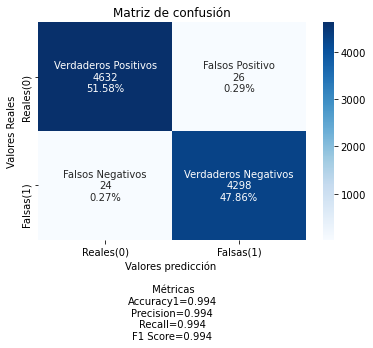

In [29]:
cm2 = confusion_matrix(y_test, pred_dt, labels=[0,1])

# group_names = ['True Neg','False Pos','False Neg','True Pos']
group_names = ['Verdaderos Positivos','Falsos Positivo','Falsos Negativos','Verdaderos Negativos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm2.flatten()/np.sum(cm2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

precision = cm2[1,1] / sum(cm2[:,1])
recall    = cm2[1,1] / sum(cm2[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\nAccuracy1={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy1,precision,recall,f1_score)

ax= plt.subplot()
sns.heatmap(cm2, annot=labels, fmt='', cmap='Blues', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted label' + stats_text)

# labels, title and ticks
ax.set_xlabel("Valores predicción \n\n Métricas" + stats_text)
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])
ax.yaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])